In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
# Data description
# Data = pd.read_csv("hotel_bookings.csv")
url = 'https://raw.githubusercontent.com/jakub-porowski/DL-OWN/main/hotel_bookings.csv'
Data = pd.read_csv(url)
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [9]:
# # Data unique values in columns
# for i in Data.columns:
#     print(i)
Data["company"].unique()

array([  0., 110., 113., 270., 178., 240., 154., 144., 307., 268.,  59.,
       204., 312., 318.,  94., 174., 274., 195., 223., 317., 281., 118.,
        53., 286.,  12.,  47., 324., 342., 373., 371., 383.,  86.,  82.,
       218.,  88.,  31., 397., 392., 405., 331., 367.,  20.,  83., 416.,
        51., 395., 102.,  34.,  84., 360., 394., 457., 382., 461., 478.,
       386., 112., 486., 421.,   9., 308., 135., 224., 504., 269., 356.,
       498., 390., 513., 203., 263., 477., 521., 169., 515., 445., 337.,
       251., 428., 292., 388., 130., 250., 355., 254., 543., 531., 528.,
        62., 120.,  42.,  81., 116., 530., 103.,  39.,  16.,  92.,  61.,
       501., 165., 291., 290.,  43., 325., 192., 108., 200., 465., 287.,
       297., 490., 482., 207., 282., 437., 225., 329., 272.,  28.,  77.,
       338.,  72., 246., 319., 146., 159., 380., 323., 511., 407., 278.,
        80., 403., 399.,  14., 137., 343., 346., 347., 349., 289., 351.,
       353.,  54.,  99., 358., 361., 362., 366., 37

In [5]:
# Nan replacement
Data["country"] = Data["country"].replace(np.nan, "unspecified", regex=True)
Data["children"] = Data["children"].replace(np.nan, 0, regex=True)
Data["agent"] = Data["agent"].replace(np.nan, 0, regex=True)
Data["company"] = Data["company"].replace(np.nan, 0, regex=True)

# ## Zastąpienie NaN w id company oraz agent zerami
# Data[['agent','company']] = Data[['agent','company']].fillna(0.0)

# ## Zastąpienie  brakujących wartości w kolumnie country modą
# Data['country'].fillna(Data.country.mode().to_string(), inplace=True)

# ## Zastąpienie brakujących wartości w kolumnie children średnią
# Data['children'].fillna(round(Data.children.mean()), inplace=True)

# ## Usunięcie wierszy z wartością zero w kolumnach adults, babies, children
# Data = Data.drop(Data[(Data.adults+Data.babies+Data.children)==0].index)

# # Zamiana typów float na int
# Data[['children', 'company', 'agent']] = Data[['children', 'company', 'agent']].astype('int64')


In [10]:
# dividing to data and target
ToDrop = ["is_canceled","arrival_date_year","arrival_date_week_number","adr","reservation_status","reservation_status_date","agent","company"]
XbeforeEncoding = Data.drop(columns=ToDrop)
y= Data["is_canceled"]
XbeforeEncoding

,hotel,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,342,July,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,737,July,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,7,July,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,0,0
3,Resort Hotel,13,July,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,14,July,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,23,August,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,0,0
119386,City Hotel,102,August,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,0,Transient,0,2
119387,City Hotel,34,August,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,0,Transient,0,4
119388,City Hotel,109,August,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,0,0


In [11]:
encoder = OneHotEncoder(sparse=False)
ColsToEncode = XbeforeEncoding[["hotel","arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type","customer_type"]]
Encoded = encoder.fit_transform(ColsToEncode)
Encoded

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [12]:
colnames = []
for cat in encoder.categories_[0]:
  colnames.append(f'hotel_{cat}')
for cat in encoder.categories_[1]:
  colnames.append(f'arrival_date_month_{cat}')
for cat in encoder.categories_[2]:
  colnames.append(f'meal_{cat}')
for cat in encoder.categories_[3]:
  colnames.append(f'country_{cat}')
for cat in encoder.categories_[4]:
  colnames.append(f'market_segment_{cat}')
for cat in encoder.categories_[5]:
  colnames.append(f'distribution_channel_{cat}')
for cat in encoder.categories_[6]:
  colnames.append(f'reserved_room_type_{cat}')
for cat in encoder.categories_[7]:
  colnames.append(f'assigned_room_type_{cat}')
for cat in encoder.categories_[8]:
  colnames.append(f'deposit_type_{cat}')
for cat in encoder.categories_[9]:
  colnames.append(f'customer_type_{cat}')

In [49]:
Encoded


array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [14]:
X = pd.DataFrame(Encoded, columns=colnames)
X[["lead_time","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","required_car_parking_spaces","total_of_special_requests"]] = XbeforeEncoding[["lead_time","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","booking_changes","days_in_waiting_list","required_car_parking_spaces","total_of_special_requests"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

In [15]:
for i in X_train.columns:
    print(i)
X_train

hotel_City Hotel
hotel_Resort Hotel
arrival_date_month_April
arrival_date_month_August
arrival_date_month_December
arrival_date_month_February
arrival_date_month_January
arrival_date_month_July
arrival_date_month_June
arrival_date_month_March
arrival_date_month_May
arrival_date_month_November
arrival_date_month_October
arrival_date_month_September
meal_BB
meal_FB
meal_HB
meal_SC
meal_Undefined
country_ABW
country_AGO
country_AIA
country_ALB
country_AND
country_ARE
country_ARG
country_ARM
country_ASM
country_ATA
country_ATF
country_AUS
country_AUT
country_AZE
country_BDI
country_BEL
country_BEN
country_BFA
country_BGD
country_BGR
country_BHR
country_BHS
country_BIH
country_BLR
country_BOL
country_BRA
country_BRB
country_BWA
country_CAF
country_CHE
country_CHL
country_CHN
country_CIV
country_CMR
country_CN
country_COL
country_COM
country_CPV
country_CRI
country_CUB
country_CYM
country_CYP
country_CZE
country_DEU
country_DJI
country_DMA
country_DNK
country_DOM
country_DZA
country_ECU
coun

,hotel_City Hotel,hotel_Resort Hotel,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,...,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
81713,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,109,21,2,1,2,0.0,0,0,1,0,0,44,0,0
81770,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,113,25,0,3,2,0.0,0,0,1,0,0,44,0,0
6724,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,47,27,1,0,1,0.0,0,0,0,0,0,0,0,0
110704,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,26,28,1,2,2,0.0,0,0,0,0,0,0,0,1
105276,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,20,31,0,4,2,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65615,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,62,6,0,3,1,0.0,0,0,0,0,0,0,0,0
77655,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,36,20,0,3,2,0.0,0,0,1,0,0,0,0,0
79683,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

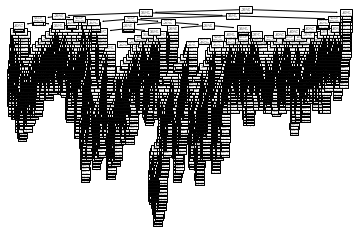

In [16]:
drzewo = DecisionTreeClassifier()
drzewo.fit(X_train, y_train)
plot_tree(drzewo)
plt.show()

In [21]:
pred = drzewo.predict(X_test)
accuracy_score(y_test, pred)

0.8403970181757267

In [19]:
params={'criterion':['gini', 'entropy'],
       'max_depth':[1, 2, 3, 4, 5,6,7,8,9,10]}
grid = GridSearchCV(estimator=drzewo, 
                    param_grid=params, 
                    verbose=10, 
                    scoring='accuracy',
                   cv=10)
grid.fit(X_train, y_train)
print(grid.best_params_,"  \  ",grid.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... criterion=gini, max_depth=1, score=0.749, total=   0.3s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.754, total=   0.3s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.747, total=   0.3s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.752, total=   0.3s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.753, total=   0.3s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.749, total=   0.3s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.754, total=   0.3s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.9s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.745, total=   0.3s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.1s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.750, total=   0.3s
[CV] criterion=gini, max_depth=1 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.4s remaining:    0.0s


[CV] ......... criterion=gini, max_depth=1, score=0.750, total=   0.3s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.749, total=   0.4s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.755, total=   0.4s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.747, total=   0.4s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.752, total=   0.4s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.754, total=   0.4s
[CV] criterion=gini, max_depth=2 .....................................
[CV] ......... criterion=gini, max_depth=2, score=0.750, total=   0.4s
[CV] criterion=gini, max_depth=2 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


{'criterion': 'gini', 'max_depth': 10}   \   0.8345024887990015


In [20]:
print(grid.best_params_,"  \  ",grid.best_score_)

{'criterion': 'gini', 'max_depth': 10}   \   0.8345024887990015


In [24]:
BestGrid =  grid.best_estimator_

[Text(243.1935944167852, 207.55636363636364, 'X[233] <= 0.5\ngini = 0.466\nsamples = 95512\nvalue = [60153, 35359]'),
 Text(155.87339082503556, 187.7890909090909, 'X[239] <= 14.5\ngini = 0.406\nsamples = 83852\nvalue = [60081, 23771]'),
 Text(74.94900426742532, 168.0218181818182, 'X[239] <= 7.5\ngini = 0.215\nsamples = 21395\nvalue = [18780, 2615]'),
 Text(35.59928876244666, 148.25454545454545, 'X[251] <= 0.5\ngini = 0.166\nsamples = 15806\nvalue = [14361, 1445]'),
 Text(34.64679943100996, 128.48727272727274, 'X[154] <= 0.5\ngini = 0.188\nsamples = 13720\nvalue = [12275, 1445]'),
 Text(16.1923186344239, 108.72, 'X[231] <= 0.5\ngini = 0.121\nsamples = 6660\nvalue = [6230, 430]'),
 Text(15.239829302987198, 88.95272727272729, 'X[203] <= 0.5\ngini = 0.119\nsamples = 6652\nvalue = [6230, 422]'),
 Text(7.619914651493599, 69.18545454545455, 'X[20] <= 0.5\ngini = 0.051\nsamples = 2863\nvalue = [2788, 75]'),
 Text(3.8099573257467996, 49.418181818181836, 'X[42] <= 0.5\ngini = 0.044\nsamples = 27

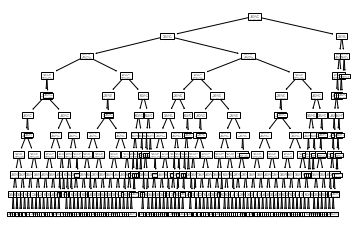

In [25]:
plot_tree(grid.best_estimator_)

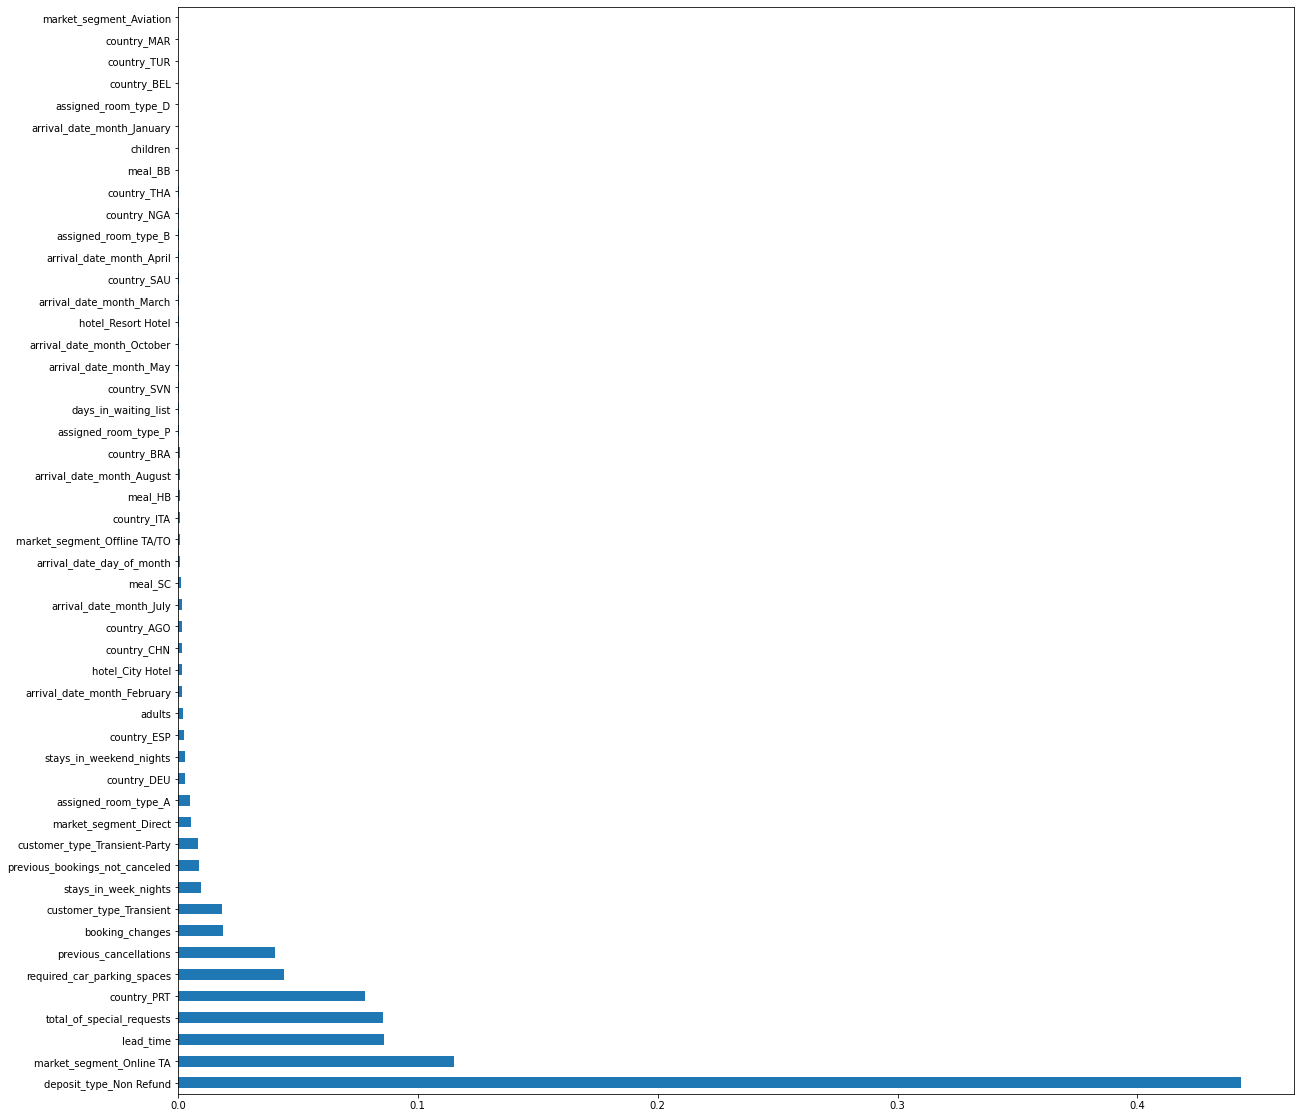

In [26]:
plt.rcParams["figure.figsize"] = (20,20)
feat_importances = pd.Series(BestGrid.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [39]:
trainpred = BestGrid.predict(X_train)
accuracy_score(y_train,trainpred)

0.8375596783650222

In [40]:
pred = BestGrid.predict(X_test)
accuracy_score(y_test, pred)

0.8357483876371555

In [44]:
XGBModel = XGBClassifier()
XGBModel.fit(X_train,y_train)
XGBPRED = XGBModel.predict(X_test)
accuracy_score(y_test,XGBPRED)

0.8382192813468464

In [ ]:
def Model():
	# create model
	model = Sequential()
	model.add(Dense(180, input_dim=253, activation='relu'))
	model.add(Dense(120, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=Model, epochs=20, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_test, y_test, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [98]:
def create_larger():
	# create model
	model = Sequential()
	model.add(Dense(253, input_dim=253, activation='relu'))
	model.add(Dense(150, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
clf = KerasClassifier(build_fn = create_larger,epochs = 50, batch_size = 5, verbose = 0)
clf.fit(X_train,y_train)

In [99]:
ypred = clf.predict(X_test)
accuracy_score(y_test,ypred)

0.8501968339056872